# Recommender systems

In recommender systems, we either assume:

- that we know the **rating** that some user gave to some item (for example, "Joseph Marchand gave 4 stars over 5 to the Suzume movie"), this is called *explicit feedback*
- that we only observe the user interacting with items in a sequence (for example, which songs are played on Spotify or YouTube in which order), but **no ratings**; this is called *implicit feedback*.

In this homework, you will build models that optimize either the first setting or the second one.

First, execute all cells to ensure you have the necessary packages.

## Part 1: Explicit feedback

In [97]:
# !pip install numpy scikit-learn torch spotlight tqdm
!pip install git+https://github.com/maciejkula/spotlight

  Cloning https://github.com/maciejkula/spotlight to /tmp/pip-req-build-udbuddji
  Running command git clone --filter=blob:none --quiet https://github.com/maciejkula/spotlight /tmp/pip-req-build-udbuddji
  Resolved https://github.com/maciejkula/spotlight to commit 75f4c8c55090771b52b88ef1a00f75bb39f9f2a9
  Preparing metadata (setup.py) ... done


In [98]:
# !pip install spotlight  # Used as baseline and for preparing datasets
import torch
from torch import nn
import numpy as np
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
from tqdm import tqdm

In [99]:
dataset = get_movielens_dataset(variant='100K')
print(dataset)

train, test = random_train_test_split(dataset)

<Interactions dataset (944 users x 1683 items x 100000 interactions)>


In [100]:
train.__dict__

{'num_users': 944,
 'num_items': 1683,
 'user_ids': array([268, 642, 455, ..., 325, 233, 196], dtype=int32),
 'item_ids': array([1249,  934,  318, ...,  655,  257,  393], dtype=int32),
 'ratings': array([2., 2., 3., ..., 4., 4., 4.], dtype=float32),
 'timestamps': array([875743793, 885606137, 879111528, ..., 891479312, 883356847,
        881251863], dtype=int32),
 'weights': None}

Users are numbered from 1 to 943 and items are numbered from 1 to 1682.  
Number of users is set to 944 and number of items is set to 1683 to avoid off-by-one errors.

In [101]:
print(f"As an example, user {train.user_ids[0]} gave {train.ratings[0]} stars to item {train.item_ids[0]}.")

As an example, user 268 gave 2.0 stars to item 1249.


In [102]:
len(train) / len(dataset)

0.8

Train / test is a 80:20 split. We should predict in the test set what is the rating for an unseen (user, item) pair: it is a regression problem.

In [103]:
%%time
model = ExplicitFactorizationModel(n_iter=3)
model.fit(train)

rmse_score(model, test)

CPU times: user 1.56 s, sys: 21.8 ms, total: 1.58 s
Wall time: 1.75 s


0.98721665

A first exercise is to reproduce this metric. We will do it together in order to make sure that we talk about the same thing, i.e.:

$$\text{RMSE}(y^*, y) = \sqrt{\frac1N \sum_{i = 1}^N (y^*_i - y_i)^2}$$

In [104]:
def our_rmse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** 0.5

In [105]:
y_pred = model.predict(test.user_ids, test.item_ids)
y_pred

array([4.958328 , 3.0055618, 2.5709307, ..., 3.0423715, 3.2789707,
       3.1752238], dtype=float32)

In [106]:
X_train = torch.LongTensor(np.column_stack((train.user_ids, train.item_ids)))
X_test = torch.LongTensor(np.column_stack((test.user_ids, test.item_ids)))
y_train = torch.Tensor(train.ratings)
y_test = torch.Tensor(test.ratings)

X_train[:5], y_train[:5]

(tensor([[ 268, 1249],
         [ 642,  934],
         [ 455,  318],
         [ 664,   97],
         [ 833, 1274]]),
 tensor([2., 2., 3., 3., 1.]))

In [107]:
our_rmse(y_test, y_pred)

tensor(0.9872)

> *Yes, I got the same thing.*

— The Social Network

In [108]:
our_rmse(y_test, torch.ones_like(y_test) * y_train.mean())  # Simplest baseline

tensor(1.1255)

In [109]:
BATCH_SIZE = 300
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [110]:
class CollaborativeFilteringModel(nn.Module):
    """
    Recommender system for explicit feedback
    """
    def __init__(self, nb_users, nb_items, embedding_size):
        super().__init__()
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.embedding_size = embedding_size

        self.user_embeddings = nn.Embedding(nb_users, embedding_size)
        self.item_embeddings = nn.Embedding(nb_items, embedding_size)
        self.func = nn.Linear(2*embedding_size, 1)
        pass

    def forward(self, x):
        # forward method for collaborative filtering model
        user_emb = self.user_embeddings(x[:, 0])
        item_emb = self.item_embeddings(x[:, 1])
        return self.func(torch.cat([user_emb, item_emb], dim=1)).squeeze()

EMBEDDING_SIZE = 20
model = CollaborativeFilteringModel(train.num_users, train.num_items, EMBEDDING_SIZE)

In [111]:
N_EPOCHS = 80
LEARNING_RATE = 0.01
loss_function = nn.MSELoss()  # It's a regression problem
# You can also check what happens where there is no weight decay i.e. no L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

100%|██████████| 80/80 [00:03<00:00, 23.84it/s]

CPU times: user 3.01 s, sys: 137 ms, total: 3.15 s
Wall time: 3.41 s


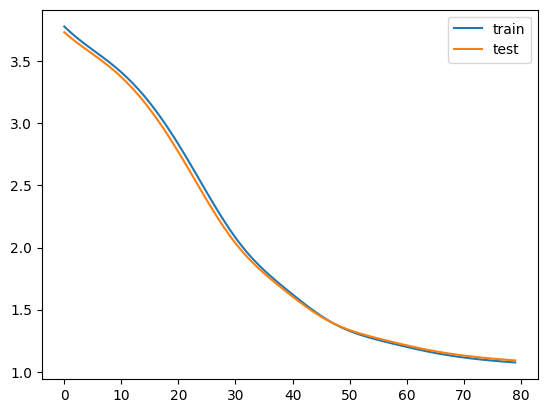

In [112]:
%%time
import math
losses_train_rmse = []
losses_test_rmse = []
for epoch in tqdm(range(N_EPOCHS)):
    # Your code here, write a training loop and plot train and test RMSE.
    # Don't forget that the loss is the mean squared error.
    # If you want to display RMSE, you need to take its square root.

    output = model(X_train)
    loss = loss_function(output, y_train)
    losses_train_rmse.append(math.sqrt(loss.item()))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    output_test = model(X_test)
    loss_test = loss_function(output_test, y_test)
    losses_test_rmse.append(math.sqrt(loss_test.item()))

# Plotting loss curves
import matplotlib.pyplot as plt
plt.plot(losses_train_rmse, label='train')
plt.plot(losses_test_rmse, label='test')
plt.legend()

## Part 2: Implicit feedback

In this section, we do not observe numerical ratings anymore, just sequences of items.

In [113]:
%%time
from spotlight.cross_validation import user_based_train_test_split
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel

# If you want to debug on a smaller dataset first, you can use this
'''from spotlight.datasets.synthetic import generate_sequential
dataset = generate_sequential(num_users=100,
                              num_items=1000,
                              num_interactions=10000,
                              concentration_parameter=0.01,
                              order=3)'''

# Otherwise we reuse Movielens
train, test = user_based_train_test_split(dataset)

train = train.to_sequence()
test = test.to_sequence()

model = ImplicitSequenceModel(n_iter=3,
                              representation='pooling',
                              loss='pointwise')
model.fit(train)

sequence_mrr_score(model, test).mean()

CPU times: user 3.74 s, sys: 4.15 ms, total: 3.74 s
Wall time: 6.77 s


0.04090704804660741

In [114]:
train

<Sequence interactions dataset (8467 sequences x 10 sequence length)>

In [115]:
train.__dict__

{'sequences': array([[ 321,  260,  329, ...,  320,  317,  181],
        [ 322,  330,  264, ...,  328,  348,  327],
        [ 332,  307,  271, ...,  335,  323,  349],
        ...,
        [ 993,  763,  475, ..., 1007,   15,    1],
        [ 294,  358,  117, ...,    7,  257,  124],
        [   0,    0,    0, ...,    0,  258,  300]], dtype=int32),
 'user_ids': array([  3,   3,   3, ..., 941, 941, 941], dtype=int32),
 'max_sequence_length': 10,
 'num_items': 1683}

The `train` dataset contains 8000+ sequences of length 10 representing the movies seen, IDs between 1 and 1683.

We do have access to user IDs but we will not need them. Here, the maximum length of a sequence is 10, so sequences have been split to be of max size 10. Sequences having less than 10 items are padded with 0s.

The objective becomes, given the first 9 items, predict the 10th item (classification). In order to have a better comparison of models, we are mainly interested in a ranking metric: in the ranked movies by probability, where was the correct answer? Mean reciprocal rank is, for $N$ samples:

$${\text{MRR}}={\frac {1}{N}}\sum _{{i=1}}^{{N}}{\frac {1}{{\text{rank}}_{i}}}$$

where $\text{rank}_i$ is a number between 1 and 1683, the number of items, which represents the rank of the expected answer, where movies are ranked by decreasing probability. The MRR is between 0 and 1 and higher is better (when all ranks are 1).

Again, we will first attempt to reproduce the metric.

In [116]:
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax

ohe = OneHotEncoder(categories=[list(range(train.num_items))])
target = ohe.fit_transform(test.sequences[:, [-1]]).toarray()

target.shape  # The target is a one-hot encoding of correct answers for each sample

(1972, 1683)

In [117]:
y_pred = []
for seq in test.sequences:
    y_pred.append(softmax(model.predict(seq[:-1])))
y_pred = np.array(y_pred)
y_pred.round(2)  # The predictions are probabilities for each sample x item

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)

In [118]:
# This function is actually more generic as it can also consider multilabel classification
# i.e. several correct answers for a sample. In our case (1 correct answer per sample) it is equal to MRR.
label_ranking_average_precision_score(target, y_pred)

0.04090704804660758

Again, we got the same number. We now show the metric for two simple baselines:

In [119]:
from collections import Counter

item_counts = Counter(train.sequences[:, -1])
most_popular_item = item_counts.most_common()[0][0]
most_popular_baseline = np.zeros_like(target)
most_popular_baseline[:, most_popular_item] = 1
label_ranking_average_precision_score(target, most_popular_baseline)

0.006675754080598566

In [120]:
popularity = np.zeros(train.num_items)
for item_id, count in item_counts.items():
    popularity[item_id] = count
popularity = softmax(popularity)
popularity_baseline = np.tile(popularity, (len(target), 1))  # Repeat for each test sample
label_ranking_average_precision_score(target, popularity_baseline)

0.024357714758922393

You should now write a model / module that takes a batch of sequences of max 9 elements and should predict the next one.

You can either take:
- a sequential approach, i.e. RNN / LSTM / GRU or a transformer like [minGPT](https://github.com/karpathy/minGPT) (which is more complex; please start simple);
- or a non-sequential one like [CBOW](https://lilianweng.github.io/posts/2017-10-15-word-embedding/#context-based-continuous-bag-of-words-cbow).

Loss can either be cross-entropy (simple), [noise contrastive estimation, or negative sampling](https://lilianweng.github.io/posts/2017-10-15-word-embedding/#noise-contrastive-estimation-nce).

The goal is to have comparable or better MRR than 0.04.

P. S. – In order to ignore index 0 you can use `padding_idx` in [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) or the function [`masked_select()`](https://pytorch.org/docs/stable/generated/torch.masked_select.html) for RNN.

In [121]:
class CBOWPredictor(nn.Module):
    def __init__(self, num_items, embedding_dim, context_size):
        super(CBOWPredictor, self).__init__()
        self.embedding = nn.Embedding(num_items, embedding_dim, padding_idx=0)
        self.fc = nn.Linear(context_size * embedding_dim, num_items)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.view(embedded.size(0), -1)  # Flatten the embeddings
        output = self.fc(embedded)
        return output

In [122]:
# now the training loop
model = CBOWPredictor(train.num_items, 20, 9)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

train_dataset = torch.utils.data.TensorDataset(torch.LongTensor(train.sequences[:, :-1]),
                                                  torch.LongTensor(train.sequences[:, -1])) # Last element is target
test_dataset = torch.utils.data.TensorDataset(torch.LongTensor(test.sequences[:, :-1]),
                                                    torch.LongTensor(test.sequences[:, -1]))

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=300, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=300, shuffle=True)

N_EPOCHS = 30

100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


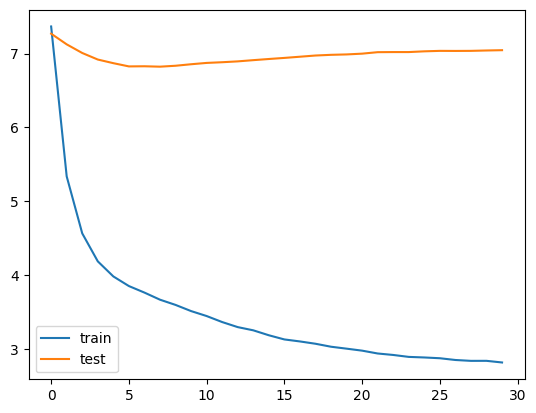

In [123]:
# Training loop
losses_train = []
losses_test = []

for epoch in tqdm(range(N_EPOCHS)):
    t_loss_train = 0
    for batch in train_iter:
        x, y = batch
        output = model(x)
        loss = loss_function(output, y)
        t_loss_train += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses_train.append(t_loss_train/len(train_iter))


    with torch.no_grad():
        t_loss_test = 0
        for batch in test_iter:
            x, y = batch
            output = model(x)
            loss = loss_function(output, y)
            t_loss_test += loss.item()
        losses_test.append(t_loss_test/len(test_iter))

# Plotting loss curves
import matplotlib.pyplot as plt
plt.plot(losses_train, label='train')
plt.plot(losses_test, label='test')
plt.legend()

In [132]:
y_pred = []
for sequences, t in test_iter:
    batch_predictions = model(sequences).detach().numpy()
    y_pred.extend(batch_predictions)
y_pred = np.array(y_pred)

In [134]:
lrap_score = label_ranking_average_precision_score(target, y_pred)
print("RMM:", lrap_score)

RMM: 0.016539502800846338
